In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

warnings.simplefilter("ignore")

In [2]:
import pathlib
sdir = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits"
bad_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits"
good_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Good Quality_Fruits"
mixed_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Mixed Qualit_Fruits"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + "_mixed")
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df 

,filepaths,labels
0,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
1,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
2,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
3,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
4,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
...,...,...
19521,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed
19522,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed
19523,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed
19524,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sdir, 
    validation_split=0.2, 
    subset="training", 
    seed=123, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE)

Found 19526 files belonging to 3 classes.
Using 15621 files for training.


2022-11-14 13:09:27.346668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 13:09:27.347615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 13:09:27.527369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 13:09:27.528231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 13:09:27.529096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sdir, 
    validation_split=0.2, 
    subset="validation", 
    seed=123, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE)

Found 19526 files belonging to 3 classes.
Using 3905 files for validation.


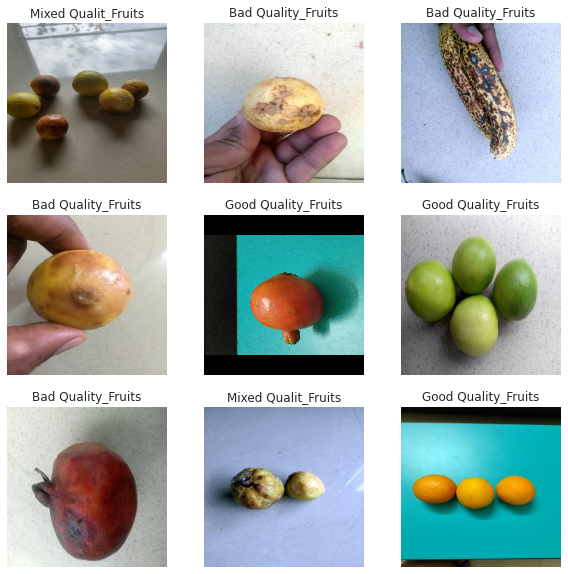

In [9]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [12]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Number of validation batches: 80
Number of test batches: 19


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

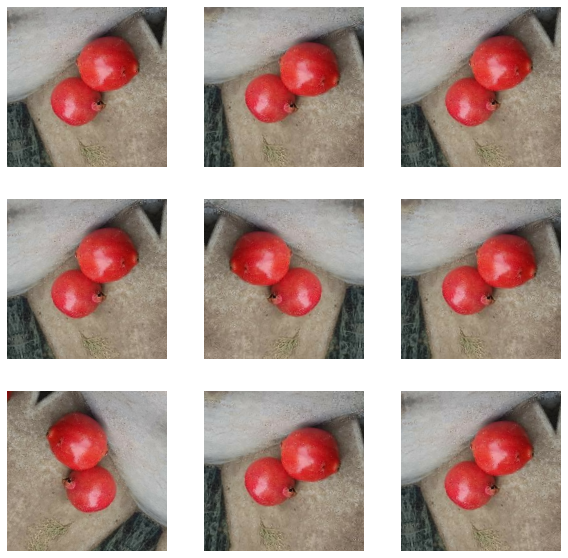

In [15]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [16]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [17]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

219070464/219055592 [==============================] - 1s 0us/step


In [19]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-11-14 13:17:18.352987: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 3, 3, 1536)


In [20]:
base_model.trainable = False

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

80/80 [==============================] - 42s 284ms/step - loss: 1.0396 - accuracy: 0.5326


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.04
initial accuracy: 0.53


In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
489/489 [==============================] - 186s 357ms/step - loss: 0.4336 - accuracy: 0.7117 - val_loss: 0.1030 - val_accuracy: 0.8201
Epoch 2/10
489/489 [==============================] - 134s 272ms/step - loss: 0.0944 - accuracy: 0.8237 - val_loss: -0.0170 - val_accuracy: 0.8493
Epoch 3/10
489/489 [==============================] - 135s 273ms/step - loss: -0.0117 - accuracy: 0.8446 - val_loss: -0.1103 - val_accuracy: 0.8565
Epoch 4/10
489/489 [==============================] - 129s 261ms/step - loss: -0.0886 - accuracy: 0.8512 - val_loss: -0.1795 - val_accuracy: 0.8573
Epoch 5/10
489/489 [==============================] - 132s 267ms/step - loss: -0.1593 - accuracy: 0.8531 - val_loss: -0.2698 - val_accuracy: 0.8561
Epoch 6/10
489/489 [==============================] - 132s 267ms/step - loss: -0.2159 - accuracy: 0.8550 - val_loss: -0.3159 - val_accuracy: 0.8612
Epoch 7/10
489/489 [==============================] - 132s 268ms/step - loss: -0.2550 - accuracy: 0.8556 - val_loss

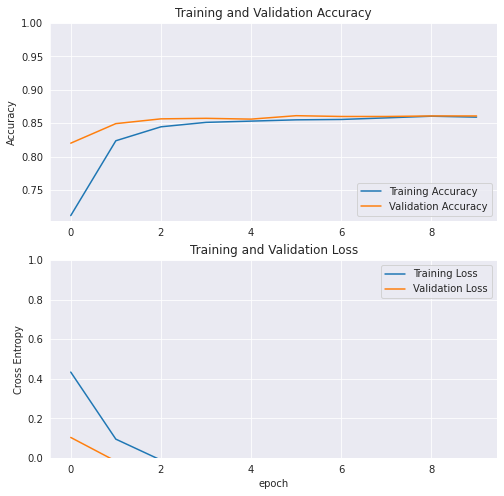

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning**

Un-freeze the top layers of the model

In [31]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  780


Compile the model

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [35]:
len(model.trainable_variables)

426

Continue training the model

In [38]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 10/20
489/489 [==============================] - 236s 424ms/step - loss: -2235809079520827277312.0000 - accuracy: 0.7258 - val_loss: -11231372862412042534912.0000 - val_accuracy: 0.7161
Epoch 11/20
489/489 [==============================] - 202s 411ms/step - loss: -19404673225250138226688.0000 - accuracy: 0.6118 - val_loss: -28607628193194229891072.0000 - val_accuracy: 0.6232
Epoch 12/20
489/489 [==============================] - 201s 408ms/step - loss: -30326017163414088974336.0000 - accuracy: 0.6119 - val_loss: -37305027081368219156480.0000 - val_accuracy: 0.5983
Epoch 13/20
489/489 [==============================] - 201s 409ms/step - loss: -37967421018161499078656.0000 - accuracy: 0.6019 - val_loss: -44940056090843086323712.0000 - val_accuracy: 0.5951
Epoch 14/20
489/489 [==============================] - 202s 410ms/step - loss: -44646160186360142495744.0000 - accuracy: 0.5967 - val_loss: -49400970600945364762624.0000 - val_accuracy: 0.5975
Epoch 15/20
489/489 [===============

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

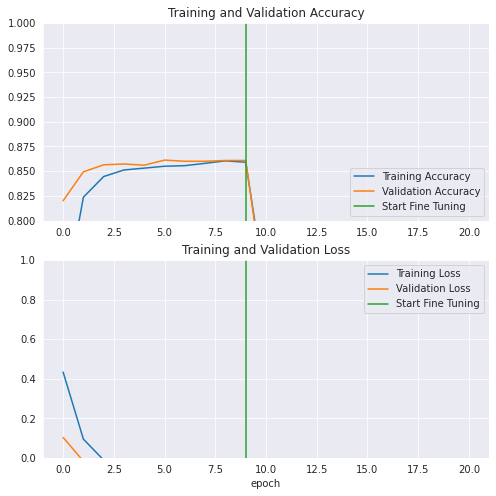

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction

In [42]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

19/19 [==============================] - 9s 194ms/step - loss: -109389021220311801004032.0000 - accuracy: 0.6957
Test accuracy : 0.6957237124443054


Predictions:
 [1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1]
Labels:
 [1 1 1 0 0 1 1 1 1 1 0 1 0 1 2 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]


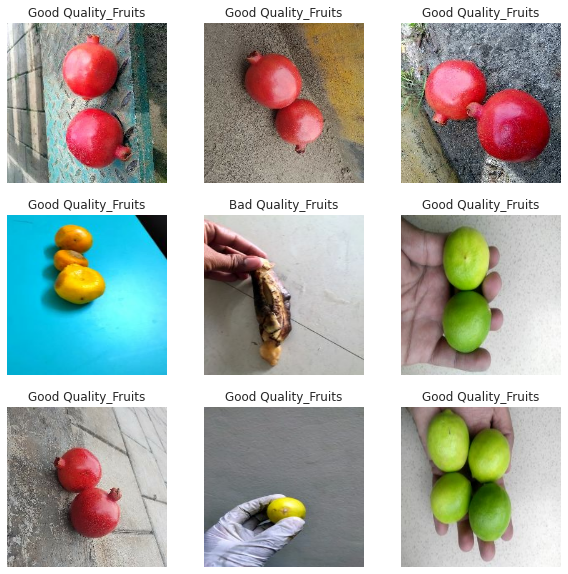

In [44]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [51]:
model.save(‘modelResNet.h5’)

SyntaxError: invalid character in identifier (2034812645.py, line 1)